<a href="https://colab.research.google.com/github/SunAndClouds/SciComp-projects/blob/main/ProjectA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
!pip install gillespy2
import gillespy2
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 7]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 395 kB 5.0 MB/s 


Matrix elements: $D_a, D_a', D_r, D_r', M_r, M_a, A, R, C, \emptyset$

parameters: 
$\alpha_a, \alpha_a', \alpha_r, \alpha_r',
\beta_a, \beta_r, \gamma_a, \gamma_r, \gamma_c,
\delta_a, \delta_r, \delta_{mr}, \delta_{ma},
\theta_a, \theta_r$

In [11]:
class Lotkavolterra_Oscillator(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Circadian rythm")
        self.volume = 1

        # model parameters: 15 in total
        self.add_parameter(Parameter(name="alpha_a", expression=50))    
        self.add_parameter(Parameter(name="alpha_ap", expression=500))   
        self.add_parameter(Parameter(name="alpha_r", expression=0.01))   
        self.add_parameter(Parameter(name="alpha_rp", expression=50))    
        self.add_parameter(Parameter(name="beta_a", expression=50)) 
        self.add_parameter(Parameter(name="beta_r", expression=5)) 
        self.add_parameter(Parameter(name="gamma_a", expression=1))    
        self.add_parameter(Parameter(name="gamma_r", expression=1))   
        self.add_parameter(Parameter(name="gamma_c", expression=2)) 
        self.add_parameter(Parameter(name="delta_a", expression=1))    
        self.add_parameter(Parameter(name="delta_r", expression=0.2)) # 0.2 for 2a and 2b, 0.05 for figure 5
        self.add_parameter(Parameter(name="delta_mr", expression=0.5)) 
        self.add_parameter(Parameter(name="delta_ma", expression=10)) 
        self.add_parameter(Parameter(name="theta_a", expression=50))   
        self.add_parameter(Parameter(name="theta_r", expression=100)) 


        # See matrix elements: 9 in total
        mode = "discrete"
        self.add_species(Species(name="D_a", initial_value=1, mode=mode))   
        self.add_species(Species(name="D_ap", initial_value=0, mode=mode)) 
        self.add_species(Species(name="D_r", initial_value=1, mode=mode))     
        self.add_species(Species(name="D_rp", initial_value=0, mode=mode))     
        self.add_species(Species(name="M_r", initial_value=0, mode=mode))     
        self.add_species(Species(name="M_a", initial_value=0, mode=mode))     
        self.add_species(Species(name="A", initial_value=0, mode=mode))     
        self.add_species(Species(name="R", initial_value=0, mode=mode))     
        self.add_species(Species(name="C", initial_value=0, mode=mode))     


        # Reactions:
        self.add_reaction(Reaction(name="r1", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(Reaction(name="r2", reactants={'A': 1}, products={}, rate=self.listOfParameters["delta_a"]))
        self.add_reaction(Reaction(name="r3", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_a"]))
        self.add_reaction(Reaction(name="r4", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_r"]))
        self.add_reaction(Reaction(name="r5",  reactants={'D_a': 1, 'A': 1}, products={'D_ap': 1}, rate=self.listOfParameters["gamma_a"]))
        self.add_reaction(Reaction(name="r6",  reactants={'D_r': 1, 'A': 1}, products={'D_rp': 1}, rate=self.listOfParameters["gamma_r"]))

        self.add_reaction(Reaction(name="r7",  reactants={'D_ap': 1}, products={'D_a': 1, "D_a": 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(Reaction(name="r8",  reactants={'D_a': 1}, products={'D_a': 1, "M_a": 1}, rate=self.listOfParameters["alpha_a"]))
        self.add_reaction(Reaction(name="r9",  reactants={'D_ap': 1}, products={'D_ap': 1, "M_a": 1}, rate=self.listOfParameters["alpha_ap"]))
        self.add_reaction(Reaction(name="r10",  reactants={'M_a': 1}, products={}, rate=self.listOfParameters["delta_ma"]))
        self.add_reaction(Reaction(name="r11",  reactants={'M_a': 1}, products={'A':1, 'M_a':1}, rate=self.listOfParameters["beta_a"]))

        self.add_reaction(Reaction(name="r12",  reactants={'D_rp': 1}, products={'A':1, 'D_r': 1}, rate=self.listOfParameters["theta_r"]))
        self.add_reaction(Reaction(name="r13",  reactants={'D_r': 1}, products={'D_r':1, 'M_r': 1}, rate=self.listOfParameters["alpha_r"]))
        self.add_reaction(Reaction(name="r14",  reactants={'D_rp': 1}, products={'D_rp':1, 'M_r': 1}, rate=self.listOfParameters["alpha_rp"]))
        self.add_reaction(Reaction(name="r15", reactants={'M_r': 1}, products={}, rate=self.listOfParameters["delta_mr"]))
        self.add_reaction(Reaction(name="r16", reactants={'M_r': 1}, products={'M_r':1, 'R':1}, rate=self.listOfParameters["beta_r"]))

        # Timespan
        self.timespan(np.linspace(0, 200, 201))

model = Lotkavolterra_Oscillator()

In [12]:
n_trajectories = 1
#'SSA', 'ODE', 'CLE', 'Tau-Leaping', or 'Tau-Hybrid'
result = model.run(algorithm="SSA", number_of_trajectories=n_trajectories)

In [13]:
c_true = result["C"]

In [14]:
class Lotkavolterra_Oscillator(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Circadian rythm")
        self.volume = 1

        # model parameters: 15 in total
        self.add_parameter(Parameter(name="alpha_a", expression=4.58175460e+01))    
        self.add_parameter(Parameter(name="alpha_ap", expression=414.34))   
        self.add_parameter(Parameter(name="alpha_r", expression=0.88))   
        self.add_parameter(Parameter(name="alpha_rp", expression=45.91))    
        self.add_parameter(Parameter(name="beta_a", expression=45.76)) 
        self.add_parameter(Parameter(name="beta_r", expression=5.08)) 
        self.add_parameter(Parameter(name="gamma_a", expression=1.32))    
        self.add_parameter(Parameter(name="gamma_r", expression=1.41))   
        self.add_parameter(Parameter(name="gamma_c", expression=1.33)) 
        self.add_parameter(Parameter(name="delta_a", expression=1.25))    
        self.add_parameter(Parameter(name="delta_r", expression=0.24)) # 0.2 for 2a and 2b, 0.05 for figure 5
        self.add_parameter(Parameter(name="delta_mr", expression=0.77)) 
        self.add_parameter(Parameter(name="delta_ma", expression=8.22)) 
        self.add_parameter(Parameter(name="theta_a", expression=50.04))   
        self.add_parameter(Parameter(name="theta_r", expression=88.84)) 


        # See matrix elements: 9 in total
        mode = "discrete"
        self.add_species(Species(name="D_a", initial_value=1, mode=mode))   
        self.add_species(Species(name="D_ap", initial_value=0, mode=mode)) 
        self.add_species(Species(name="D_r", initial_value=1, mode=mode))     
        self.add_species(Species(name="D_rp", initial_value=0, mode=mode))     
        self.add_species(Species(name="M_r", initial_value=0, mode=mode))     
        self.add_species(Species(name="M_a", initial_value=0, mode=mode))     
        self.add_species(Species(name="A", initial_value=0, mode=mode))     
        self.add_species(Species(name="R", initial_value=0, mode=mode))     
        self.add_species(Species(name="C", initial_value=0, mode=mode))     


        # Reactions:
        self.add_reaction(Reaction(name="r1", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(Reaction(name="r2", reactants={'A': 1}, products={}, rate=self.listOfParameters["delta_a"]))
        self.add_reaction(Reaction(name="r3", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_a"]))
        self.add_reaction(Reaction(name="r4", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_r"]))
        self.add_reaction(Reaction(name="r5",  reactants={'D_a': 1, 'A': 1}, products={'D_ap': 1}, rate=self.listOfParameters["gamma_a"]))
        self.add_reaction(Reaction(name="r6",  reactants={'D_r': 1, 'A': 1}, products={'D_rp': 1}, rate=self.listOfParameters["gamma_r"]))

        self.add_reaction(Reaction(name="r7",  reactants={'D_ap': 1}, products={'D_a': 1, "D_a": 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(Reaction(name="r8",  reactants={'D_a': 1}, products={'D_a': 1, "M_a": 1}, rate=self.listOfParameters["alpha_a"]))
        self.add_reaction(Reaction(name="r9",  reactants={'D_ap': 1}, products={'D_ap': 1, "M_a": 1}, rate=self.listOfParameters["alpha_ap"]))
        self.add_reaction(Reaction(name="r10",  reactants={'M_a': 1}, products={}, rate=self.listOfParameters["delta_ma"]))
        self.add_reaction(Reaction(name="r11",  reactants={'M_a': 1}, products={'A':1, 'M_a':1}, rate=self.listOfParameters["beta_a"]))

        self.add_reaction(Reaction(name="r12",  reactants={'D_rp': 1}, products={'A':1, 'D_r': 1}, rate=self.listOfParameters["theta_r"]))
        self.add_reaction(Reaction(name="r13",  reactants={'D_r': 1}, products={'D_r':1, 'M_r': 1}, rate=self.listOfParameters["alpha_r"]))
        self.add_reaction(Reaction(name="r14",  reactants={'D_rp': 1}, products={'D_rp':1, 'M_r': 1}, rate=self.listOfParameters["alpha_rp"]))
        self.add_reaction(Reaction(name="r15", reactants={'M_r': 1}, products={}, rate=self.listOfParameters["delta_mr"]))
        self.add_reaction(Reaction(name="r16", reactants={'M_r': 1}, products={'M_r':1, 'R':1}, rate=self.listOfParameters["beta_r"]))

        # Timespan
        self.timespan(np.linspace(0, 200, 201))

model = Lotkavolterra_Oscillator()

n_trajectories = 1
#'SSA', 'ODE', 'CLE', 'Tau-Leaping', or 'Tau-Hybrid'
result = model.run(algorithm="SSA", number_of_trajectories=n_trajectories)
c_pred = result["C"]

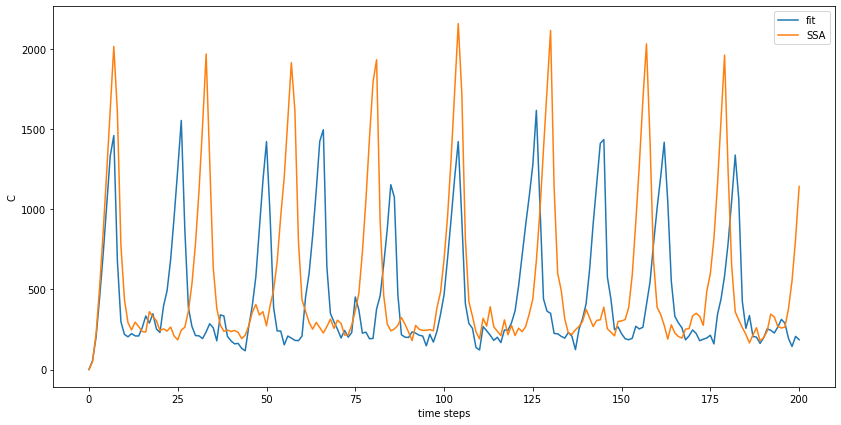

In [18]:
plt.plot(c_pred, label="fit")
plt.plot(c_true, label="SSA")
plt.ylabel("C"), plt.xlabel("time steps")
plt.legend()
plt.savefig("SSA vs pinv")